# Data Forecasting

The module is in charge of: 
- forecasting the value of temperature in the next X seconds; 
- forecasting the value of humidity in the next X seconds; 
- forecasting the value of the gas sensor in the next X seconds 

(X is defined by users or developers). 

The time-series of the predicted values must be saved on INFLUX and shown on the GRAFANA dashboard as well; e.g. by using two lines for the temperature graph, one related to raw measurements, one to predictions. One or multiple techniques for time-series forecasting can be developed and compared.


## Import Dependencies

In [ ]:
!pip3 install influxdb_client
!pip3 install statsmodels
!pip3 install sklearn
!pip3 install cufflinks
!pip3 install pmdarima
!pip3 install chart-studio

In [64]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
import random
from datetime import datetime,timezone
import dateutil.parser
import time
import statsmodels.graphics.tsaplots as tsaplots
from datetime import timedelta
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.write_api import WriteType

## Influx Setting

In [65]:
INFLUXDB_HOST = os.getenv("INFLUX_HOST")
INFLUXDB_PORT = os.getenv("INFLUX_HOST_PORT")
INFLUXDB_ORG = os.getenv("INFLUX_ORG")
INFLUXDB_TOKEN = os.getenv("INFLUX_TOKEN")
client = InfluxDBClient(url="http://"+INFLUXDB_HOST+":"+INFLUXDB_PORT, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)

### Influx Queries

[<FluxTable: 12 columns, 142 records>, <FluxTable: 12 columns, 29 records>]
[<FluxTable: 12 columns, 142 records>, <FluxTable: 12 columns, 29 records>]
[<FluxTable: 12 columns, 142 records>]


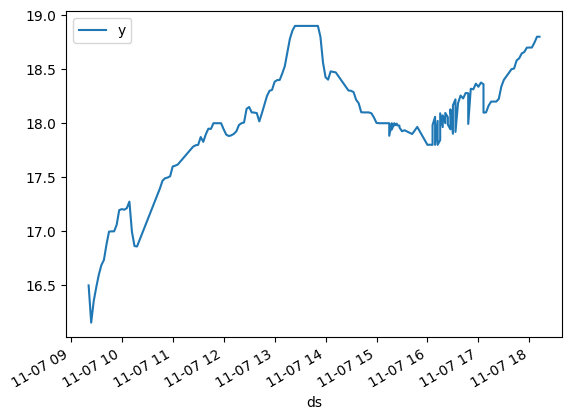

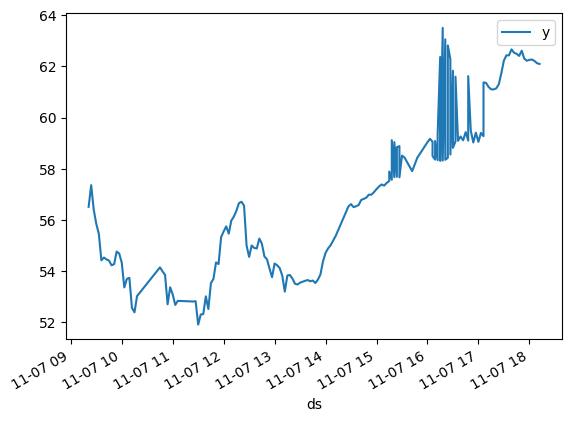

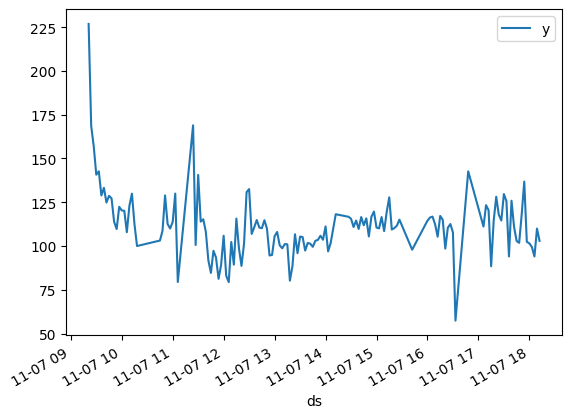

In [126]:
from pandas import DataFrame


def result_to_dataframe(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_time(), record.get_value()))
    return pd.DataFrame(raw, columns=['ds','y'], index=None)
    
buckets = ['temperature', 'humidity', 'gas']
dfTemp = DataFrame
dfHum = DataFrame
dfGas = DataFrame

for bucket in buckets:
    query = 'from(bucket: "' + bucket + '")' \
                ' |> range(start: 2022-11-07T09:00:00.00Z, stop: 2022-11-07T19:50:00.00Z)' \
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "'+ bucket + '")' \
                ' |> aggregateWindow(every: 1m , fn: mean, createEmpty: false)'\
                ' |> yield(name: "mean")'\

    result = client.query_api().query(org=INFLUXDB_ORG, query=query)
    print(result)
    # Convert the results to dataframe
    if (bucket == "temperature" and  result):
        dfTemp = result_to_dataframe(result)
        dfTemp['ds'] = dfTemp['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfTemp[plot_cols]
        plot_features.index = dfTemp['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "humidity" and result):
        dfHum = result_to_dataframe(result)
        dfHum['ds'] = dfHum['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfHum[plot_cols]
        plot_features.index = dfHum['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "gas" and result):
        dfGas = result_to_dataframe(result)
        dfGas['ds'] = dfGas['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfGas[plot_cols]
        plot_features.index = dfGas['ds']
        _ = plot_features.plot(subplots=True)

### Informations about DataFrames. Train and Test Datasets cretion 

In [133]:
trainTemp = DataFrame
testTemp = DataFrame
trainHum= DataFrame
testHum = DataFrame
trainGas = DataFrame
testGas = DataFrame
global tempDate
global humDate
global gasDate

if ( not dfTemp.empty):
    print("Temperature Dataset")    
    print(dfTemp.describe().transpose())
    nrows = (len(dfTemp.values))
    splitPoint = int (nrows * 0.80)
    trainTemp = dfTemp['y'] [:splitPoint]
    testTemp = dfTemp ['y'] [splitPoint:]
    tempDate = dfTemp ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    tempDate['ds'] = tempDate.ds.dt.floor('min')

if (not dfHum.empty):
    print("Humidity Dataset")
    print(dfHum.describe().transpose())
    nrows = (len(dfHum.values))
    splitPoint = int (nrows * 0.80)
    trainHum = dfHum['y'] [:splitPoint]
    testHum = dfHum ['y'] [splitPoint:]
    humDate = dfHum ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    humDate['ds'] = humDate.ds.dt.floor('min')   

if (not dfGas.empty):
    print("Gas Dataset")
    print(dfGas.describe().transpose())
    nrows = (len(dfGas.values))
    splitPoint = int (nrows * 0.80)
    trainGas = dfGas['y'] [:splitPoint]
    testGas = dfGas ['y'] [splitPoint:]
    gasDate = dfGas ['ds'] [splitPoint:].to_frame().reset_index()
    # truncate ds to minutes
    humDate['ds'] = humDate.ds.dt.floor('min')

IndentationError: unexpected indent (2921741197.py, line 10)

### Check if the time-series are stationary using the Dickey-Fuller test

In [129]:
from statsmodels.tsa.stattools import adfuller

resultTemp = 0.0
resultHum = 0.0
resultGas = 0.0

if (not dfTemp.empty):
    resultTemp = adfuller(trainTemp)
    print('TEMPERATURE: ADF Statistic: %f' % resultTemp[0])
    print('TEMPERATURE: p-value: %f' % resultTemp[1])

if (not dfHum.empty):
    resultHum = adfuller(trainHum)
    print('HUMIDITY: ADF Statistic: %f' % resultHum[0])
    print('HUMIDITY: p-value: %f' % resultHum[1])

if (not dfGas.empty):
    resultGas = adfuller(trainGas)
    print('GAS: ADF Statistic: %f' % resultGas[0])
    print('GAS: p-value: %f' % resultGas[1])
    

TEMPERATURE: ADF Statistic: -3.575559
TEMPERATURE: p-value: 0.006246
HUMIDITY: ADF Statistic: -1.390633
HUMIDITY: p-value: 0.586759
GAS: ADF Statistic: -5.302507
GAS: p-value: 0.000005


### If P Value > 0.05 we go ahead with finding the order of differencing.

HUMIDITY: ADF Statistic: -4.238989
HUMIDITY: new p-value: 0.000566


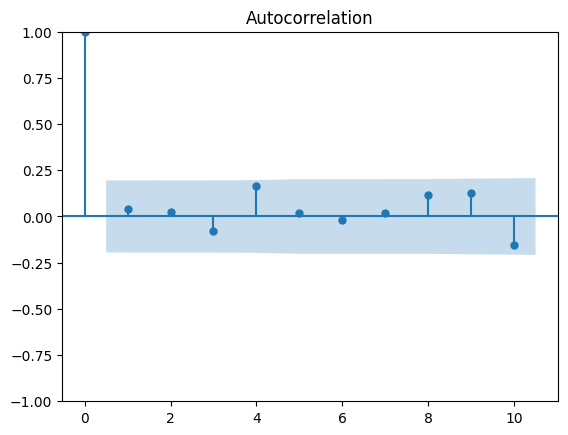

/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



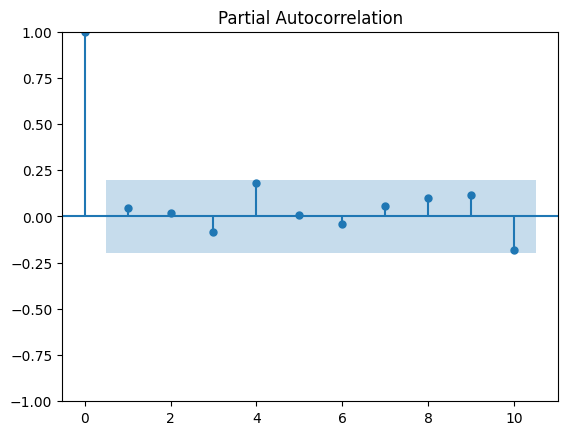

In [130]:
from statsmodels.graphics import tsaplots

if (not dfTemp.empty and resultTemp[1] > 0.05):
    train_new = trainTemp.diff().dropna()
    result = adfuller(train_new)
    print('TEMPERATURE: ADF Statistic: %f' % result[0])
    print('TEMPERATURE: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfHum.empty and resultHum[1] > 0.05):
    train_new = trainHum.diff().dropna()
    result = adfuller(train_new)
    print('HUMIDITY: ADF Statistic: %f' % result[0])
    print('HUMIDITY: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfGas.empty and resultGas[1] > 0.05):
    train_new = trainGas.diff().dropna()
    result = adfuller(train_new)
    print('GAS: ADF Statistic: %f' % result[0])
    print('GAS: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

### Apply ARIMA model to all Datasets

In [131]:
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_squared_error

if (not trainTemp.empty):
  historyTemp = [x for x in trainTemp]
  predictionsTemp = list()
if (not trainHum.empty):
  historyHum = [x for x in trainHum]
  predictionsHum = list()
if (not trainGas.empty):
  historyGas= [x for x in trainGas]
  predictionsGas = list()

if (not dfTemp.empty):
  for t in testTemp.index:
    model = ARIMA(historyTemp, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yest = output[0]
    predictionsTemp.append(yest)
    obs= testTemp[t]
    historyTemp.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfHum.empty):
  for t in testHum.index:
    model = ARIMA(historyHum, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yest = output[0]
    predictionsHum.append(yest)
    obs= testHum[t]
    historyHum.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfGas.empty):
  for t in testGas.index:
    model = ARIMA(historyGas, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yest = output[0]
    predictionsGas.append(yest)
    obs= testGas[t]
    historyGas.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))


/Users/riccardobaratin/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



predicted=17.941309, expected=18.000000
predicted=17.972741, expected=17.995833
predicted=17.940116, expected=17.961224
predicted=17.938708, expected=17.900000
predicted=17.882472, expected=17.800000
predicted=17.840394, expected=17.801389
predicted=17.880004, expected=17.800000
predicted=17.840531, expected=17.800000
predicted=17.876459, expected=17.800000
predicted=17.841761, expected=17.844444
predicted=17.915347, expected=17.963889
predicted=17.958812, expected=18.000000
predicted=17.952669, expected=17.987692
predicted=17.947534, expected=17.943548
predicted=17.911183, expected=17.902778
predicted=17.906942, expected=17.920000
predicted=17.927115, expected=17.993333
predicted=17.977658, expected=18.097959
predicted=18.029922, expected=18.100000
predicted=17.984319, expected=18.162500
predicted=18.087794, expected=18.200000
predicted=18.028132, expected=18.200000
predicted=18.086411, expected=18.200000
predicted=18.033868, expected=18.225000
predicted=18.109086, expected=18.338889


In [132]:
def send_predictions(df, date, bucket):
	lines = [str(df['y'][d]) for d in range(len(df))]

	lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " " + bucket + '=' + str(df['y'][d])
										+ ' ' + str(int(time.mktime(date['ds'][d].timetuple()))) + "000000000" for d in range(len(date))]
	
	write_client = client.write_api(write_options=WriteOptions(batch_size=1000, flush_interval=10_000,
															jitter_interval=2_000, retry_interval=5_000, write_type=WriteType.synchronous))
	write_client.write(bucket, INFLUXDB_ORG, lines)

### ARIMA model evaluation (RMSE)

Test RMSE: 0.218


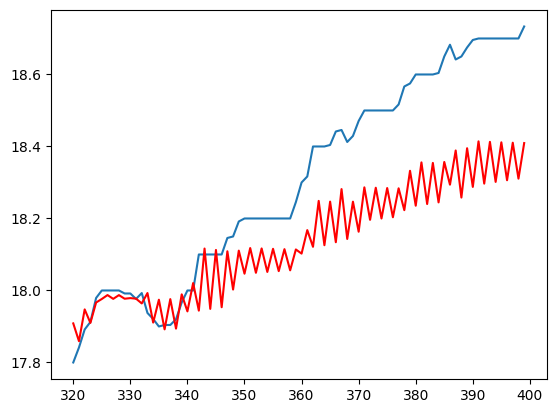

Test RMSE: 3.315


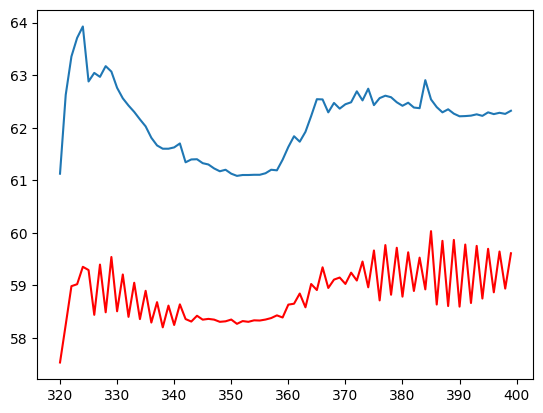

Test RMSE: 28.781


ApiException: (422)
Reason: Unprocessable Entity
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json; charset=utf-8', 'X-Influxdb-Build': 'OSS', 'X-Influxdb-Version': '2.4.0', 'X-Platform-Error-Code': 'unprocessable entity', 'Date': 'Mon, 07 Nov 2022 18:05:32 GMT', 'Content-Length': '215'})
HTTP response body: {"code":"unprocessable entity","message":"failure writing points to database: partial write: field type conflict: input field \"gas\" on measurement \"val\" is type float, already exists as type integer dropped=80"}


In [120]:
if (not trainTemp.empty):
  rmse = math.sqrt(mean_squared_error(testTemp, predictionsTemp))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsTemp)
  df.columns = ['y']
  send_predictions(df, tempDate, "temperature")
  df.set_index(testTemp.index, inplace=True)
  plt.plot(testTemp)
  plt.plot(df, color='red')
  plt.show()

if (not trainHum.empty):
  rmse = math.sqrt(mean_squared_error(testHum, predictionsHum))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsHum)
  df.columns = ['y']
  send_predictions(df, humDate, "humidity")
  df.set_index(testHum.index, inplace=True)
  plt.plot(testHum)
  plt.plot(df, color='red')
  plt.show()
if (not trainGas.empty):
  rmse = math.sqrt(mean_squared_error(testGas, predictionsGas))
  print('Test RMSE: %.3f'% rmse)
  df = pd.DataFrame(predictionsGas)
  df.columns = ['y']
  df["y"] = df["y"].astype(int)
  send_predictions(df, gasDate, "gas")
  df.set_index(testGas.index, inplace=True)
  plt.plot(testGas)
  plt.plot(df, color='red')
  plt.show()